<a href="https://colab.research.google.com/github/UBela/BV-ML-CV-Praktikum/blob/main/license_plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import torch
from torchvision import transforms
from create_dataset import Licenseplates
import pre_process_data

In [8]:
#create dataset
path_images = '../data/images/'
path_annotations = '../data/annotations/'
dataset = Licenseplates(path_images, path_annotations)

{'filename': 'Cars0.png', 'width': 500, 'height': 268, 'class': 0, 'bounding_box': [226, 125, 419, 173]}


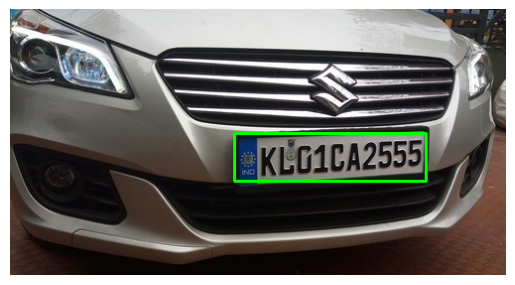

In [16]:
#example of image and bounding box
image, ann = dataset[0]
bb = ann['bounding_box']
print(ann)
image_array = np.array(image)
cv2.rectangle(image_array, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 2)
image_with_rectangle = Image.fromarray(image_array)
plt.imshow(image_with_rectangle)
plt.axis('off')
plt.show()

In [11]:
#split dataset into image and annotations
annotations = []
images = []
for image, annotation in dataset:
    images.append(image)
    annotations.append(annotation)

In [12]:
#pre-process images and annotations
processed_images = pre_process_data.preprocess_images(images)
processed_annotations = pre_process_data.preprocess_annotations(annotations)

C:\Users\belau\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(416, 416, 3)


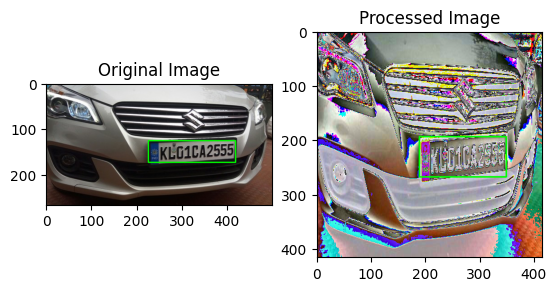

Original Annotation:
[226, 125, 419, 173]
Processed Annotation:
tensor([0.5560, 0.3860, 0.1791, 0.0000])


In [13]:
# Check processed images
# Display original and processed images side by side
fig, axes = plt.subplots(1, 2)

# Original image
original_image = np.array(images[0])
og_annotation = annotations[0]  # Select an original annotation
bb = og_annotation['bounding_box']
cv2.rectangle(original_image, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 2)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")

# Processed image
processed_image = processed_images[0]
processed_image_pil = transforms.ToPILImage()(processed_image)
processed_image = np.array(processed_image_pil)
print(processed_image.shape)  # Select the corresponding processed image
processed_annotation = processed_annotations[0]
xc, yc, w, h = processed_annotation[:-1]
xmin = int((xc - w / 2.0) * processed_image.shape[1])
ymin = int((yc - h / 2.0) * processed_image.shape[0])
xmax = int(xmin + w * processed_image.shape[1])
ymax = int(ymin + h * processed_image.shape[0])
cv2.rectangle(processed_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
axes[1].imshow(processed_image)
axes[1].set_title("Processed Image")

plt.show()

# Processed annotation
print("Original Annotation:")
print(og_annotation['bounding_box'])

print("Processed Annotation:")
print(processed_annotation[1:])

In [14]:
print(processed_images.shape)
print(processed_annotations.shape)

torch.Size([433, 3, 416, 416])
torch.Size([433, 5])


In [15]:
#split into train and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# get pretrained yolo model:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 k